# 해야 할 것들
1. CLAHE 정리해둘것

In [1]:
# 필요한 라이브러리 및 모듈

import numpy as np
import cv2
import butter
from matplotlib import pyplot as plt

In [2]:
# 1. Read Video file

# generate video object
filename = "./input/original_video_SR30.mp4"
cap = cv2.VideoCapture(filename)

In [3]:
# 2. Gray Scale로 변환

# 첫번째 프레임 읽기
ret, frame = cap.read()

# 영상의 사이즈 확인
frame_size = frame.shape
print("Shape of image is : ",frame.shape)

# Gray Sacle 이미지로 변환
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
print("Shape of image is : ",gray.shape)

Shape of image is :  (256, 640, 3)
Shape of image is :  (256, 640)


### Histogram 과 CLAHE

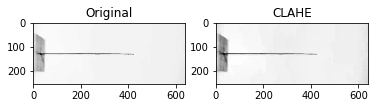

In [4]:
# contrast limit가 2이고 title의 size는 8X8
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
img2 = clahe.apply(gray)
plt.subplot(121),plt.imshow(gray, cmap = 'gray'),plt.title('Original')
plt.subplot(122),plt.imshow(img2, cmap = 'gray'),plt.title('CLAHE')
plt.show()

In [5]:
def CLAHE(input):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    output = clahe.apply(input)
    return output

### Gaussian pyramid
In a Gaussian pyramid, subsequent images are **weighted down using a Gaussian average (Gaussian blur) and scaled down.** Each pixel containing a local average corresponds to a neighborhood pixel on a lower level of the pyramid. This technique is used especially in texture synthesis.

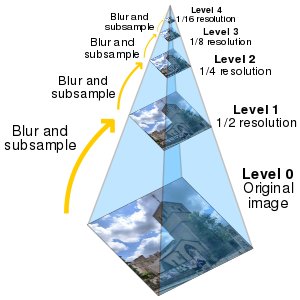

### Laplacian pyramid
A Laplacian pyramid is very similar to a Gaussian pyramid but saves the difference image of the blurred versions between each levels. Only the smallest level is not a difference image to enable reconstruction of the high resolution image using the difference images on higher levels. This technique can be used in image compression

__출처 : https://en.wikipedia.org/wiki/Pyramid_(image_processing)__

In [6]:
# pyramid 안쓰고, resize함수로 피라미드 정의

def pyramidDown(input):
    # input is numpy array
    heigh, width = input.shape
    #output = np.zeros((size[0]//2, size[1]//2))
    blur = cv2.GaussianBlur(input, (5,5), 0) # 블러는 얼마나 줄 지 고찰해보도록
    output = cv2.resize(input, None, fx = 0.5, fy = 0.5)
    return output

def pyramidUp(input):
    # input is numpy array
    heigh, width = input.shape
    #output = np.zeros((size[0]//2, size[1]//2))
    output = cv2.resize(input, None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC) #interpolatino 수정 바람
    return output

In [7]:
# 3. Generate Pyramid
Gau_seq = [[],[],[],[],[],[]]
Lap_seq = [[],[],[],[],[],[]]

while ret:
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = CLAHE(gray)
    
    # Normalize intensity
    gray = gray.astype('float32')
    gray = gray / 255
    
    Gau = [gray]
    Down = pyramidDown(gray)
    Gau.append(Down)

    for i in range (0,5):
        Down = pyramidDown(Down)
        Gau.append(Down)
    
    Gau_copy = []
    Gau_copy[:] = Gau
    Gau_copy.reverse()
    
    for i in range (0,6):
        Gau_seq[i].append(Gau_copy.pop())

    Lap = []
    for i in range (0, 6):
        Up = pyramidUp(Gau.pop())
        Lap.append(Up - Gau[len(Gau)-1])

    #Lap.reverse()
    
    for i in range (0,6):
        Lap_seq[i].append(Lap.pop())
    ret, frame = cap.read()

In [8]:
# 4. 확대 주파수 결정 및 필터링
# Parameter Initializing 

SR = 2200 # SR is Sampling Rate
Fn = SR/2
T = 1/SR # T is Period
Low_freq = 350/(2*3.141592)
High_freq = 370/(2*3.141592)
alpha = 400

In [9]:
# pyramid data 저장
'''
f = open('LaplacianPramid_L0_0.csv', 'a')

np.savetxt(f, np.column_stack((Lap_seq[0][0])), delimiter=",", fmt='%s',  newline='\n')'''

'\nf = open(\'LaplacianPramid_L0_0.csv\', \'a\')\n\nnp.savetxt(f, np.column_stack((Lap_seq[0][0])), delimiter=",", fmt=\'%s\',  newline=\'\n\')'

### Matlab 과 Scipy의 butter filter 파라미터 차이

Matlab과 같은 파라미터를 입력했을 때 차이가 난 이유가 뭘까?
바로 두 파라미터를 다루는 방식에 있다.

매트랩이 받는 방식 : [b,a] = butter(order,[lowcut, highcut])
Scipy가 받는 방식  : butter_bandpass(lowcut, highcut, fs, order=5) -> (b,a)

__Matlab__은 차단 주파수의 단위가 __rad/sample__ 이고, __scipy__는 단지 __Hz__이다.

이 방식 차이가 오차를 만들어 내는 것으로 추정된다.
따라서 매트랩과 같은 변수를 써 주려면, 원래 값을 2*pi로 나누어 주어야 한다.

In [10]:
# 원하는 주파수 선택적으로 확대 
import time
start = time.time()
#f=open('python_bandpass.csv','a')

frame_size = Lap_seq[0][0].shape

# level 0
for i in range (0, frame_size[0]):
    for j in range (0, frame_size[1]):
        time_stack = []
        
        for k in range (0, 100):
            time_stack.append(Lap_seq[0][k][i][j])
            
        time_stack = butter.butter_bandpass_filter(time_stack, Low_freq, High_freq, SR, order=5)
        #np.savetxt(f, np.column_stack(time_stack), delimiter=",", fmt='%s',  newline='\n')
        for k in range (0, 100):
            Lap_seq[0][k][i][j] += alpha * time_stack[k]
            
end = time.time()
delay = end - start
print("1st level : ", delay)

1st level :  126.43437361717224


In [11]:
# level 1 
start = time.time()
for i in range (0, Lap_seq[1][0].shape[0]):
    for j in range (0, Lap_seq[1][0].shape[1]):
        time_stack = []
        
        for k in range (0, 100):
            time_stack.append(Lap_seq[1][k][i][j])
            
        time_stack = butter.butter_bandpass_filter(time_stack, Low_freq, High_freq, SR, order=5)
        
        for k in range (0, 100):
            Lap_seq[1][k][i][j] += alpha * time_stack[k]
            
end = time.time()
delay = end - start
print("2nd level : ", delay)

2nd level :  28.590587377548218


In [12]:
# level 2
start = time.time()

for i in range (0, Lap_seq[2][0].shape[0]):
    for j in range (0, Lap_seq[2][0].shape[1]):
        time_stack = []
        
        for k in range (0, 100):
            time_stack.append(Lap_seq[2][k][i][j])
            
        time_stack = butter.butter_bandpass_filter(time_stack, Low_freq, High_freq, SR, order=5)
        
        for k in range (0, 100):
            Lap_seq[2][k][i][j] += time_stack[k]
            
end = time.time()
delay = end - start
print("3nd level : ", delay)

3nd level :  7.0393359661102295


In [13]:
# 변환했던 부동소수점 데이터를 다시 정수로 변환

for i in range(0, 3):
    for j in range(0, 100):
        Lap_seq[i][j] *= 255
        Lap_seq[i][j] = Lap_seq[i][j].astype('uint8')

for i in range(0, 3):
    for j in range(0, 100):
        Gau_seq[i][j] *= 255
        Gau_seq[i][j] = Gau_seq[i][j].astype('uint8')
        

In [14]:
# 5. 동영상으로 저장하기
# 영상 스택 쌓기

Rec2= []
for i in range (0, 100):
    Rec2.append(Lap_seq[2][i] + Gau_seq[2][i])

for i in range (0, 100):
    Rec2[i] = pyramidUp(Rec2[i])

Rec1 = []
for i in range (0, 100):
    Rec1.append(Lap_seq[1][i] + Rec2[i])

for i in range (0, 100):
    Rec1[i] = pyramidUp(Rec1[i])

Rec0 = []
for i in range (0, 100):
    Rec0.append(Lap_seq[0][i] + Rec1[i] )

In [27]:
Rec2= []
for i in range (0, 100):
    Sum = cv2.add(Lap_seq[2][i], Gau_seq[2][i])
    Rec2.append(Sum)

for i in range (0, 100):
    Rec2[i] = pyramidUp(Rec2[i])

Rec1 = []
for i in range (0, 100):
    Sum = cv2.add(Lap_seq[1][i], Rec2[i])
    Rec1.append(Sum)
    
for i in range (0, 100):
    Rec1[i] = pyramidUp(Rec1[i])

Rec0 = []
for i in range (0, 100):
    Sum = cv2.add(Lap_seq[0][i], Rec1[i])
    Rec0.append(Sum)

In [24]:
cv2.add(Lap_seq[1][1], Rec2[1])

array([[226, 226, 226, ..., 255, 255, 255],
       [226, 226, 226, ..., 251, 254, 247],
       [226, 226, 226, ..., 230, 228, 227],
       ...,
       [236, 236, 236, ..., 217, 237, 255],
       [236, 236, 236, ..., 255, 255, 255],
       [236, 236, 236, ..., 213, 211, 206]], dtype=uint8)

In [18]:
cv2.add(Lap_seq[1][i], Gau_seq[1][i])

array([[226, 226, 226, ..., 235, 235, 235],
       [226, 226, 226, ..., 232, 233, 255],
       [226, 226, 226, ..., 229, 231, 232],
       ...,
       [239, 239, 239, ..., 211, 214, 255],
       [239, 239, 239, ..., 255, 255, 255],
       [239, 239, 239, ..., 207, 207, 208]], dtype=uint8)

In [28]:
# Output 파일 생성 

size = Rec0[0].shape

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('./output/' + 'alpha_' + str(alpha) + 'output.mp4', fourcc, 30.0, (640, 256), isColor = False)

for i in range (0, len(Rec0)):
    #out.write(cv2.cvtColor(Rec0[i], cv2.COLOR_GRAY2RGB))
    out.write(Rec0[i])
#    cv2.imshow('frame', Rec0[i])
#    if cv2.waitKey(0) & 0xFF == ord('q'):
#            break

#cv2.destroyAllWindows()
            
out.release()

print("done")
print(size)

done
(256, 640)


In [ ]:
from matplotlib import pyplot as plt
plt.imshow(pyramidUp(Lap_seq[2][1] + Gau_seq[2][1]) + Lap_seq[1][1], cmap = 'gray')

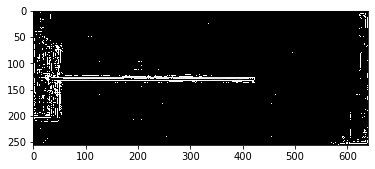

In [33]:
plt.imshow(Lap_seq[0][0], cmap = 'gray')

In [34]:
Lap_seq[0][0]

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   1,   0,   0],
       ...,
       [  0,   0,   0, ..., 254, 255,   0],
       [  0,   0,   0, ...,   0,   1,   1],
       [  0,   0,   0, ...,   1,   0,   0]], dtype=uint8)